In [1]:
import pandas as pd
import pyodbc
import pgeocode
from datamart import fix_me

In [2]:
username = 'vigrose'
password_edw = 'Gryffindor~10946'
w = "DSN=PRDDW; UID={}; PWD={}".format(username, password_edw)
AMAEDW = pyodbc.connect(w)

In [3]:
#Get ppd
ppd = pd.read_csv('../../Data/PPD/ppd_data_20210501.csv')
ppd['ME'] = fix_me(ppd.ME)

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (13,14,20,21,42,49,56,57,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Get party ids
ME_QUERY = \
    """
    SELECT DISTINCT
    P.PARTY_ID,
    P.KEY_VAL AS ME
    FROM
    AMAEDW.PARTY_KEY P
    WHERE
    P.KEY_TYPE_ID = 18
    AND
    P.ACTIVE_IND = 'Y'
    """
party_ids = pd.read_sql(con=AMAEDW, sql=ME_QUERY)

In [5]:
#Get polos
sql_query_polo = \
    '''
    SELECT DISTINCT
    A.PARTY_ID,
    A.POST_CD_ID,
    A.CAT_CD_ID,
    P.ADDR_1,
    P.ADDR_2,
    P.ADDR_3,
    P.CITY,
    S.SRC_STATE_CD AS STATE,
    P.POST_CD AS ZIP,
    A.FROM_DT,
    P.SRC_POST_KEY AS POST_KEY
    FROM
    AMAEDW.POST_CD P, AMAEDW.STATE S , AMAEDW.PARTY_ADDR A, AMAEDW.CONT_PURPOSE_TYPE C
    WHERE
    A.PURPOSE_TYPE_ID=C.PURPOSE_TYPE_ID
    AND
    C.PURPOSE_CAT_CD='A'
    AND
    C.PURPOSE_USG_CD='PO'
    AND
    A.POST_CD_ID = P.POST_CD_ID
    AND
    P.STATE_ID = S.STATE_ID
    AND
    A.THRU_DT IS NULL;
    '''
POLOS = pd.read_sql(con=AMAEDW, sql=sql_query_polo)

In [58]:
#Get polos
sql_query_polo_2 = \
    '''
    SELECT DISTINCT
    A.PARTY_ID,
    A.POST_CD_ID,
    A.CAT_CD_ID,
    P.ADDR_1,
    P.ADDR_2,
    P.ADDR_3,
    P.CITY,
    S.SRC_STATE_CD AS STATE,
    P.POST_CD AS ZIP,
    A.FROM_DT,
    P.SRC_POST_KEY AS COMM_ID
    FROM
    AMAEDW.POST_CD P, AMAEDW.STATE S , AMAEDW.PARTY_ADDR A, AMAEDW.CONT_PURPOSE_TYPE C
    WHERE
    A.PURPOSE_TYPE_ID=C.PURPOSE_TYPE_ID
    AND
    C.PURPOSE_CAT_CD='A'
    AND
    C.PURPOSE_USG_CD='PO'
    AND
    A.POST_CD_ID = P.POST_CD_ID
    AND
    P.STATE_ID = S.STATE_ID
    AND
    A.THRU_DT IS NULL;
    '''
POLOS_2 = pd.read_sql(con=AMAEDW, sql=sql_query_polo_2)

In [55]:
#Get polos
other_polo = \
    '''
    SELECT DISTINCT
    A.PARTY_ID,
    A.POST_CD_ID,
    P.ADDR_1,
    P.ADDR_2,
    P.ADDR_3,
    P.CITY,
    S.SRC_STATE_CD AS STATE,
    P.POST_CD AS ZIP,
    A.FROM_DT,
    P.SRC_POST_KEY AS POST_KEY,
    CC.DESC,
    CC.CATEGORY_CODE
    FROM
    AMAEDW.POST_CD P, AMAEDW.STATE S , AMAEDW.PARTY_ADDR A, AMAEDW.CONT_PURPOSE_TYPE C, AMAEDW.CAT_CD CC
    WHERE
    A.PURPOSE_TYPE_ID=C.PURPOSE_TYPE_ID
    AND
    C.PURPOSE_CAT_CD='A'
    AND
    C.PURPOSE_USG_CD='PO'
    AND
    A.POST_CD_ID = P.POST_CD_ID
    AND
    P.STATE_ID = S.STATE_ID
    AND
    A.THRU_DT IS NULL
    AND
    CC.CAT_CD_ID = A.CAT_CD_ID;
    '''
OTHER_POLOS = pd.read_sql(con=AMAEDW, sql=other_polo)

In [6]:
#Get ppmas
sql_query_ppma = \
    '''
    SELECT DISTINCT
    A.PARTY_ID,
    A.POST_CD_ID,
    P.ADDR_1,
    P.ADDR_2,
    P.ADDR_3,
    P.CITY,
    S.SRC_STATE_CD AS STATE_CD,
    P.POST_CD AS ZIP,
    A.FROM_DT
    FROM
    AMAEDW.POST_CD P, AMAEDW.STATE S , AMAEDW.PARTY_ADDR A, AMAEDW.CONT_PURPOSE_TYPE C
    WHERE
    A.PURPOSE_TYPE_ID=C.PURPOSE_TYPE_ID
    AND
    C.PURPOSE_CAT_CD='A'
    AND
    C.PURPOSE_USG_CD='PP'
    AND
    A.POST_CD_ID = P.POST_CD_ID
    AND
    P.STATE_ID = S.STATE_ID
    AND
    A.THRU_DT IS NULL
        '''
PPMAS = pd.read_sql(con=AMAEDW, sql=sql_query_ppma)

In [7]:
#Merge ppma, polo
addresses = pd.merge(POLOS, PPMAS, on='PARTY_ID', suffixes = ['_POLO','_PPMA'])

In [8]:
addresses.head()

,PARTY_ID,POST_CD_ID_POLO,ADDR_1_POLO,ADDR_2_POLO,ADDR_3_POLO,CITY_POLO,STATE,ZIP_POLO,FROM_DT_POLO,POST_KEY,POST_CD_ID_PPMA,ADDR_1_PPMA,ADDR_2_PPMA,ADDR_3_PPMA,CITY_PPMA,STATE_CD,ZIP_PPMA,FROM_DT_PPMA
0,1849882,16269589,2603 University Blvd,,,Tuscaloosa,AL,35401,2005-12-16 20:20:34.850978,713677,16510132,1215 Indian Hills Dr,,,Tuscaloosa,AL,35406,2005-12-16 20:35:12.695826
1,1843314,16267642,633 S Union Ave,,,Ozark,AL,36360,2005-12-16 20:20:34.853611,713743,16262160,491 Country Club Dr,363609-037,,Ozark,AL,36360,2005-12-16 20:23:03.538796
2,1849885,13850597,9135 Piscataway Rd Ste 235,,,Clinton,MD,20735,2005-12-16 20:20:34.854390,713765,14073785,4507 Leland St,,,Chevy Chase,MD,20815,2008-01-14 22:13:37.950041
3,1888588,12193084,1106 Druid Rd S,,,Clearwater,FL,33756,2005-12-16 20:20:34.858320,713865,12323166,1106 Druid Rd S,,,Clearwater,FL,33756,2005-12-16 20:33:48.736206
4,1798055,16183293,106 Medical Arts Bldg,,,Anniston,AL,36201,2005-12-16 20:20:34.860548,713910,16090223,534 Hillyer High Rd,,,Anniston,AL,36207,2005-12-16 20:22:59.225699


In [9]:
#Add party ids and identify missing POLOs
PPD = pd.merge(ppd, party_ids, on = 'ME')
PPD = PPD.fillna('None')
no_polo = PPD[(PPD.POLO_MAILING_LINE_1=='None')&(PPD.POLO_MAILING_LINE_2=='None')]
print(len(no_polo))

310391


In [10]:
#Find filtered
filtered_polos = pd.merge(no_polo, addresses, on='PARTY_ID')
print(len(filtered_polos))

85287


In [13]:
filtered_dpc = filtered_polos[filtered_polos.TOP_CD == 20]

In [18]:
newers = []
for row in filtered_dpc.itertuples():
    newer = False
    if row.FROM_DT_POLO > row.FROM_DT_PPMA:
        newer = True
    newers.append(newer)

In [33]:
filtered_dpc = filtered_dpc.rename(columns ={'STATE_CD':'STATE_PPMA','STATE_x':'STATE','STATE_y':'STATE_POLO'})
filtered_dpc['POLO_NEWER'] = newers
newer = filtered_dpc[filtered_dpc.POLO_NEWER == True]

In [34]:
len(newer)

36127

### How many POLO addresses are being filtered out at present?
#### 85,287
### How many of those belong to DPC physicians?
#### 59,321
### For the DPC physicians, how many of the POLO addresses are newer than their PPMA addresses?
#### 36,127

In [35]:
newer[['FROM_DT_PPMA','FROM_DT_POLO','POLO_STATE','STATE_POLO','STATE', 'STATE_PPMA']]

,FROM_DT_PPMA,FROM_DT_POLO,POLO_STATE,STATE_POLO,STATE,STATE_PPMA
0,2017-03-08 21:23:41.403872,2019-06-09 21:07:06.564450,None,FL,NC,NC
1,2018-01-18 20:44:52.770769,2019-08-30 21:14:05.014631,None,GA,FL,FL
3,2014-09-16 20:58:22.293098,2019-06-28 21:11:23.387724,None,TX,ID,ID
4,2016-11-14 22:47:47.265223,2018-12-13 20:47:32.910158,None,WA,CA,CA
5,2017-11-07 20:43:42.359930,2019-11-24 21:08:12.997853,None,WI,CA,CA
...,...,...,...,...,...,...
85278,2013-11-11 22:24:20.032365,2017-09-27 20:43:55.176354,None,WA,VA,VA
85279,2014-06-04 21:17:03.192236,2019-07-26 21:09:10.857077,None,VT,NJ,NJ
85280,2019-05-14 21:08:55.253213,2020-06-21 21:06:44.124354,None,CT,TX,TX
85282,2011-10-07 22:10:36.573332,2019-11-17 21:08:14.467934,None,OH,FL,FL


In [32]:
filtered_dpc[filtered_dpc.POLO_NEWER == True]

In [36]:
len(ppd)

1281054

In [38]:
no_polo[no_polo.TOP_CD == 20]

,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,MAILING_LINE_1,...,POLO_ZIP,POLO_SECTOR,POLO_CARRIER_ROUTE,MOST_RECENT_FORMER_LAST_NAME,MOST_RECENT_FORMER_MIDDLE_NAME,MOST_RECENT_FORMER_FIRST_NAME,NEXT_MOST_RECENT_FORMER_LAST,NEXT_MOST_RECENT_FORMER_MIDDLE,NEXT_MOST_RECENT_FORMER_FIRST,PARTY_ID
0,00102000013,A,1,2,MICHAEL J STANFORD MD,STANFORD,MICHAEL,JAMES,None,None,...,None,None,None,None,None,None,None,None,None,1849563
18,00102000200,A,1,2,CHARLES R BLAKE MD,BLAKE,CHARLES,RICHARD,None,APT1026,...,None,None,None,None,None,None,None,None,None,1903170
27,00102000307,A,1,2,MITCHELL D BRANTLEY MD,BRANTLEY,MITCHELL,DAVID,None,None,...,None,None,None,None,None,None,None,None,None,1798003
37,00102000412,A,1,2,ERIC J BRAY MD,BRAY,ERIC,JAY,None,None,...,None,None,None,None,None,None,None,None,None,1888539
69,00102000749,A,1,2,KIM C WIGGINS MD,WIGGINS,KIM,CHERI,None,None,...,None,None,None,WIGGINS,CHERI,K,None,None,None,1903176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280972,96501020050,A,1,2,NIMESH H NAIK MD,NAIK,NIMESH,HARISH,None,None,...,None,None,None,None,None,None,None,None,None,3394313
1280989,96501770059,A,1,2,ASHABEN P PATEL MD,PATEL,ASHABEN,P,None,None,...,None,None,None,PATEL,PARBHOOBHAI,A,None,None,None,2853636
1281016,96501830051,A,1,2,CHRISTOPHER T DA COSTA MD,DA COSTA,CHRISTOPHER,T K,None,None,...,None,None,None,ABOAGYE-DA COSTA,None,CHRIS,DA COSTA,K,CHRISTOPHER,2691881
1281025,96501860058,A,1,2,MWENDALUBI YASA MD,YASA,MWENDALUBI,None,None,None,...,None,None,None,None,None,None,None,None,None,2832075


In [39]:
ppd[ppd.TOP_CD == 20]

,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,MAILING_LINE_1,...,POLO_STATE,POLO_ZIP,POLO_SECTOR,POLO_CARRIER_ROUTE,MOST_RECENT_FORMER_LAST_NAME,MOST_RECENT_FORMER_MIDDLE_NAME,MOST_RECENT_FORMER_FIRST_NAME,NEXT_MOST_RECENT_FORMER_LAST,NEXT_MOST_RECENT_FORMER_MIDDLE,NEXT_MOST_RECENT_FORMER_FIRST
0,00102000013,A,1,2.0,MICHAEL J STANFORD MD,STANFORD,MICHAEL,JAMES,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00102000030,A,1,1.0,MARK T JACKSON MD,JACKSON,MARK,THOMAS,NaN,NaN,...,NC,28805,1262.0,C082,NaN,NaN,NaN,NaN,NaN,NaN
3,00102000048,A,1,2.0,NADHIWAN S MAISIAK MD,MAISIAK,NADHIWAN,SAKARIN,NaN,NaN,...,AZ,85375,5282.0,C045,NaN,NaN,NaN,NaN,NaN,NaN
4,00102000056,A,1,2.0,RAJIV B GALA MD,GALA,RAJIV,BABULAL,NaN,NaN,...,LA,70115,6949.0,C003,NaN,NaN,NaN,NaN,NaN,NaN
5,00102000064,A,1,2.0,CAROL L ADAMS MD,ADAMS,CAROL,LYNN,NaN,NaN,...,AL,35504,2516.0,C009,DANIELS,LYNN,CAROL,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281045,96501940019,A,1,1.0,MUKUL GUPTA MD,GUPTA,MUKUL,NaN,NaN,NaN,...,CA,93105,4230.0,C013,NaN,NaN,NaN,NaN,NaN,NaN
1281046,96501950014,A,1,2.0,DINESH BHASKARAN MD,BHASKARAN,DINESH,NaN,NaN,NaN,...,PA,15009,9727.0,R001,NaN,NaN,NaN,NaN,NaN,NaN
1281050,96501960036,A,1,2.0,KAMISHELE MAILA MD,MAILA,KAMISHELE,NaN,NaN,NaN,...,OH,45801,4667.0,C005,NaN,NaN,NaN,NaN,NaN,NaN
1281051,96501960044,A,1,2.0,MWIZA GAUSI MD,GAUSI,MWIZA,NaN,NaN,NaN,...,VA,24541,2987.0,C002,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
newer

,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,MAILING_LINE_1,...,POST_KEY,POST_CD_ID_PPMA,ADDR_1_PPMA,ADDR_2_PPMA,ADDR_3_PPMA,CITY_PPMA,STATE_PPMA,ZIP_PPMA,FROM_DT_PPMA,POLO_NEWER
0,00102000200,A,1,2,CHARLES R BLAKE MD,BLAKE,CHARLES,RICHARD,None,APT1026,...,23584424,25957830,2211 Hillsborough Rd Apt 1026,APT1026,,Durham,NC,27705,2017-03-08 21:23:41.403872,True
1,00102000307,A,1,2,MITCHELL D BRANTLEY MD,BRANTLEY,MITCHELL,DAVID,None,None,...,23793378,12412047,297 Plantation Hill Rd,,,Gulf Breeze,FL,32561,2018-01-18 20:44:52.770769,True
3,00102000749,A,1,2,KIM C WIGGINS MD,WIGGINS,KIM,CHERI,None,None,...,12142212,13517884,211 9th Ave N,,,Twin Falls,ID,83301,2014-09-16 20:58:22.293098,True
4,00102001575,A,1,2,JEFFREY CHOU MD,CHOU,JEFFREY,None,None,None,...,22999259,26904785,34018 Stetson Way,,,Fremont,CA,94555,2016-11-14 22:47:47.265223,True
5,00102002351,A,1,1,SUNNY C YUNG MD,YUNG,SUNNY,CHUNG,None,NORTHERN CALIFORNIA HEALTH CARE SYSTEM,...,13791447,28125454,10535 Hospital Way,Northern California Health Care System,Limited To Official Federal Duties Only,Mather,CA,95655,2017-11-07 20:43:42.359930,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85278,95708940021,A,1,2,ELDINA VAJZOVIC-NIZAMIC MD,VAJZOVIC-NIZAMIC,ELDINA,None,None,None,...,15442244,23561012,8320 Abuja Pl,Apt 1,,Dulles,VA,20189,2013-11-11 22:24:20.032365,True
85279,95709000013,A,1,1,NORA GASHI MD,GASHI,NORA,None,None,None,...,23684723,13796281,468 Parish Dr,,,Wayne,NJ,07470,2014-06-04 21:17:03.192236,True
85280,95709080017,A,1,1,BLERIM ARIFI MD,ARIFI,BLERIM,None,None,JPS HOSPITAL,...,1362975,20587286,1500 S Main St,Jps Hospital,,Fort Worth,TX,76104,2019-05-14 21:08:55.253213,True
85282,96501020050,A,1,2,NIMESH H NAIK MD,NAIK,NIMESH,HARISH,None,None,...,24104729,21336382,5701 Rusack Dr,,,Melbourne,FL,32940,2011-10-07 22:10:36.573332,True


In [53]:
parties = tuple(newer.PARTY_ID)
#Sourcing
sql_query = \
        f'''
        SELECT DISTINCT
        A.PARTY_ID,
        A.POST_CD_ID,
        CC.DESC,
        CC.CATEGORY_CODE
        FROM
        AMAEDW.POST_CD P, AMAEDW.PARTY_ADDR A, AMAEDW.CAT_CD CC, AMAEDW.CONT_PURPOSE_TYPE C
        WHERE
        CC.CAT_CD_ID = A.CAT_CD_ID
        AND
        A.PARTY_ID in {parties}
        AND
        A.PURPOSE_TYPE_ID=C.PURPOSE_TYPE_ID
        AND
        C.PURPOSE_USG_CD='PO'
        AND
        C.PURPOSE_CAT_CD='A'
        AND
        A.THRU_DT IS NULL
        '''
sourcing = pd.read_sql(con=AMAEDW, sql=sql_query)

In [54]:
sourcing

,PARTY_ID,POST_CD_ID,DESC,CATEGORY_CODE
0,2390541,9128232,TELEPHONE SURVEY DATA,PHNSURV
1,3405874,9128253,TELEPHONE SURVEY DATA,PHNSURV
2,2061822,9128373,TELEPHONE SURVEY DATA,PHNSURV
3,3558187,9128373,TELEPHONE SURVEY DATA,PHNSURV
4,1934364,9128484,TELEPHONE SURVEY DATA,PHNSURV
...,...,...,...,...
31926,5883417,32228496,TELEPHONE SURVEY DATA,PHNSURV
31927,2378316,32228497,TELEPHONE SURVEY DATA,PHNSURV
31928,5171903,32228503,TELEPHONE SURVEY DATA,PHNSURV
31929,2782638,32228505,TELEPHONE SURVEY DATA,PHNSURV


In [49]:
pd.merge(sourcing, newer, on='PARTY_ID')

,PARTY_ID,POST_CD_ID,ADDR_1,ADDR_2,ADDR_3,CITY_x,ZIP_x,DESC,CATEGORY_CODE,ME,...,POST_KEY,POST_CD_ID_PPMA,ADDR_1_PPMA,ADDR_2_PPMA,ADDR_3_PPMA,CITY_PPMA,STATE_PPMA,ZIP_PPMA,FROM_DT_PPMA,POLO_NEWER
0,2390541,9128232,10666 N Torrey Pines Rd,,,La Jolla,92037,TELEPHONE SURVEY DATA,PHNSURV,03840721557,...,715505,12882826,834 Eaton Park Ln,,,Akron,OH,44303,2019-05-08 21:08:08.131985,True
1,3405874,9128253,2 W Fern Ave,,,Redlands,92373,TELEPHONE SURVEY DATA,PHNSURV,64914030836,...,715766,23297396,804 Shallowater Dr,,,Allen,TX,75013,2013-07-30 21:14:19.421352,True
2,3405874,11807511,1303 W Evergreen Ave,,,Effingham,62401,TELEPHONE SURVEY DATA,PHNSURV,64914030836,...,715766,23297396,804 Shallowater Dr,,,Allen,TX,75013,2013-07-30 21:14:19.421352,True
3,4567256,9128336,10666 N Torrey Pines Rd,,,La Jolla,92037,TELEPHONE SURVEY DATA,PHNSURV,03520100449,...,14442485,26732299,450 Broadway St,Mc 6342,Stanford Medicine,Redwood City,CA,94063,2016-08-17 22:33:19.604979,True
4,4567256,20985320,10710 N Torrey Pines Rd,,,La Jolla,92037,TELEPHONE SURVEY DATA,PHNSURV,03520100449,...,14442485,26732299,450 Broadway St,Mc 6342,Stanford Medicine,Redwood City,CA,94063,2016-08-17 22:33:19.604979,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51378,2247708,32228435,4014 Leavenworth St,,,Omaha,68105,TELEPHONE SURVEY DATA,PHNSURV,03005890321,...,25841652,20931627,PO Box 34293,,,Omaha,NE,68134,2011-01-04 21:40:06.624818,True
51379,5883417,32228496,2805 Earl Rudder Fwy S,,,College Station,77845,TELEPHONE SURVEY DATA,PHNSURV,03605141284,...,25841655,31821157,17361 Makawee Ct,,,College Sta,TX,77845,2020-11-06 21:16:48.774349,True
51380,2378316,32228497,,777 S Lindar Road,,Batesville,29607,TELEPHONE SURVEY DATA,PHNSURV,03901930545,...,25841656,30700536,9523 E 109th St,,,Tulsa,OK,74133,2020-03-13 21:08:42.793263,True
51381,2782638,32228505,,Isabel II Esquina Degetau Cl,,Bayamon,00960,TELEPHONE SURVEY DATA,PHNSURV,30803814631,...,25841674,20031968,E53 Calle A,Repto Montellano,,Cayey,PR,00736,2009-09-18 21:15:01.851352,True


In [45]:
len(newer)

36127

In [46]:
newer.drop_duplicates('ME')

,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,MAILING_LINE_1,...,POST_KEY,POST_CD_ID_PPMA,ADDR_1_PPMA,ADDR_2_PPMA,ADDR_3_PPMA,CITY_PPMA,STATE_PPMA,ZIP_PPMA,FROM_DT_PPMA,POLO_NEWER
0,00102000200,A,1,2,CHARLES R BLAKE MD,BLAKE,CHARLES,RICHARD,None,APT1026,...,23584424,25957830,2211 Hillsborough Rd Apt 1026,APT1026,,Durham,NC,27705,2017-03-08 21:23:41.403872,True
1,00102000307,A,1,2,MITCHELL D BRANTLEY MD,BRANTLEY,MITCHELL,DAVID,None,None,...,23793378,12412047,297 Plantation Hill Rd,,,Gulf Breeze,FL,32561,2018-01-18 20:44:52.770769,True
3,00102000749,A,1,2,KIM C WIGGINS MD,WIGGINS,KIM,CHERI,None,None,...,12142212,13517884,211 9th Ave N,,,Twin Falls,ID,83301,2014-09-16 20:58:22.293098,True
4,00102001575,A,1,2,JEFFREY CHOU MD,CHOU,JEFFREY,None,None,None,...,22999259,26904785,34018 Stetson Way,,,Fremont,CA,94555,2016-11-14 22:47:47.265223,True
5,00102002351,A,1,1,SUNNY C YUNG MD,YUNG,SUNNY,CHUNG,None,NORTHERN CALIFORNIA HEALTH CARE SYSTEM,...,13791447,28125454,10535 Hospital Way,Northern California Health Care System,Limited To Official Federal Duties Only,Mather,CA,95655,2017-11-07 20:43:42.359930,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85278,95708940021,A,1,2,ELDINA VAJZOVIC-NIZAMIC MD,VAJZOVIC-NIZAMIC,ELDINA,None,None,None,...,15442244,23561012,8320 Abuja Pl,Apt 1,,Dulles,VA,20189,2013-11-11 22:24:20.032365,True
85279,95709000013,A,1,1,NORA GASHI MD,GASHI,NORA,None,None,None,...,23684723,13796281,468 Parish Dr,,,Wayne,NJ,07470,2014-06-04 21:17:03.192236,True
85280,95709080017,A,1,1,BLERIM ARIFI MD,ARIFI,BLERIM,None,None,JPS HOSPITAL,...,1362975,20587286,1500 S Main St,Jps Hospital,,Fort Worth,TX,76104,2019-05-14 21:08:55.253213,True
85282,96501020050,A,1,2,NIMESH H NAIK MD,NAIK,NIMESH,HARISH,None,None,...,24104729,21336382,5701 Rusack Dr,,,Melbourne,FL,32940,2011-10-07 22:10:36.573332,True


In [52]:
len(parties)

36127

In [56]:
OTHER_POLOS

,PARTY_ID,POST_CD_ID,ADDR_1,ADDR_2,ADDR_3,CITY,STATE,ZIP,FROM_DT,POST_KEY,DESC,CATEGORY_CODE
0,2135294,15279367,7701 State Line Rd,,,Kansas City,MO,64114,2016-10-18 07:22:59.042096,1286324,Phone Call,PHONE-CALL
1,2664009,10292981,1175 Montauk Hwy Ste 1,,,West Islip,NY,11795,2016-10-18 07:22:59.445103,3288931,Telephone Survey,PHNSURV
2,2336726,13691337,405 Northfield Ave,Ste 204,,West Orange,NJ,07052,2016-10-18 07:22:59.950862,5445470,White Paper Mail,WHITE-MAIL
3,2537472,14738419,Medical Center Blvd,Wake Forest Univ Dept Rad,,Winston Salem,NC,27157,2016-10-18 07:23:00.628196,6153569,Telephone Survey,PHNSURV
4,2717698,12341036,7300 SW 62nd Pl,Fl 2,,South Miami,FL,33143,2016-10-18 07:23:00.662517,6162980,Telephone Survey,PHNSURV
...,...,...,...,...,...,...,...,...,...,...,...,...
480537,9453939,32229403,2100 W Central Ave,2nd Ave,,Toledo,OH,43606,2021-05-03 20:46:41.652140,25842882,Phone Call,PHONE-CALL
480538,2067371,32229431,800 Adams Ave,Ste 200,,Norristown,PA,19403,2021-05-03 20:46:41.806892,25843200,Other Source,OTHER
480539,2818406,32229414,901 W Main St,Center State Hospital,,Freehold,NJ,07728,2021-05-03 20:46:41.923953,25843373,Phone Call,PHONE-CALL
480540,2079692,32229439,600 Grant St,Fl 11,UPMD Heath Plan,Pittsburgh,PA,15219,2021-05-03 20:46:42.573192,25843530,White Paper Mail,WHITE-MAIL


In [59]:
POLOS_2

,PARTY_ID,POST_CD_ID,CAT_CD_ID,ADDR_1,ADDR_2,ADDR_3,CITY,STATE,ZIP,FROM_DT,POST_KEY
0,1849882,16269589,NaN,2603 University Blvd,,,Tuscaloosa,AL,35401,2005-12-16 20:20:34.850978,713677
1,1843314,16267642,NaN,633 S Union Ave,,,Ozark,AL,36360,2005-12-16 20:20:34.853611,713743
2,1849885,13850597,NaN,9135 Piscataway Rd Ste 235,,,Clinton,MD,20735,2005-12-16 20:20:34.854390,713765
3,1888588,12193084,NaN,1106 Druid Rd S,,,Clearwater,FL,33756,2005-12-16 20:20:34.858320,713865
4,1798055,16183293,NaN,106 Medical Arts Bldg,,,Anniston,AL,36201,2005-12-16 20:20:34.860548,713910
...,...,...,...,...,...,...,...,...,...,...,...
1157769,9453939,32229403,3812.0,2100 W Central Ave,2nd Ave,,Toledo,OH,43606,2021-05-03 20:46:41.652140,25842882
1157770,2067371,32229431,3923.0,800 Adams Ave,Ste 200,,Norristown,PA,19403,2021-05-03 20:46:41.806892,25843200
1157771,2818406,32229414,3812.0,901 W Main St,Center State Hospital,,Freehold,NJ,07728,2021-05-03 20:46:41.923953,25843373
1157772,2079692,32229439,3813.0,600 Grant St,Fl 11,UPMD Heath Plan,Pittsburgh,PA,15219,2021-05-03 20:46:42.573192,25843530


In [61]:
len(ppd)-len(no_polo)

970663

In [62]:
480542/1157774

0.41505682456161563

In [69]:
entity_ids = \
    """
    SELECT DISTINCT
    P.PARTY_ID,
    P.KEY_VAL AS ENTITY_ID
    FROM
    AMAEDW.PARTY_KEY P
    WHERE
    P.KEY_TYPE_ID = '9'
    """
ENTITY_ID = pd.read_sql(con=AMAEDW, sql=entity_ids)

In [70]:
ENTITY_ID

,PARTY_ID,ENTITY_ID
0,7556000,46715886
1,7556001,46715899
2,7556002,46715912
3,7556003,46715925
4,7556004,46715938
...,...,...
4250632,16162040,65959348
4250633,16162041,65959361
4250634,16162042,65959374
4250635,16162043,65959387


In [74]:
newer = pd.merge(ENTITY_ID, newer, on='PARTY_ID')
entity_list = tuple(newer.ENTITY_ID)

In [76]:
password_aims = 'DQA8K@T7pXEqEt'
s = "DSN=aims_prod; UID={}; PWD={}".format(username, password_aims)
informix = pyodbc.connect(s)

In [78]:
query_3 = \
    f'''
    SELECT DISTINCT
    U.ENTITY_ID,
    U.COMM_ID,
    U.SRC_CAT_CODE
    FROM
    informix.ENTITY_COMM_USG_AT U
    WHERE
    U.COMM_USAGE = 'PO'
    AND
    U.ENTITY_ID in {entity_list}
    AND
    U.END_DT IS NULL
    ;
    '''
aims_check = pd.read_sql(con=informix, sql=query_3)
aims_check.head()

,entity_id,comm_id,src_cat_code
0,1234827,23584424,PHNSURV
1,1234957,23793378,NPI
2,1235529,12142212,DEA
3,1236153,22999259,WEBPHYC
4,1236621,13791447,PHNSURV


In [92]:
newer = pd.merge(aims_check, newer, on='ENTITY_ID')

In [85]:
newer.dtypes

PARTY_ID                 int64
ENTITY_ID               object
ME                      object
RECORD_ID               object
UPDATE_TYPE              int64
                     ...      
CITY_PPMA               object
STATE_PPMA              object
ZIP_PPMA                object
FROM_DT_PPMA    datetime64[ns]
POLO_NEWER                bool
Length: 101, dtype: object

In [90]:
aims_check['ENTITY_ID'] = aims_check.entity_id.astype(str)

In [103]:
pd.merge(newer, sourcing, on='PARTY_ID', how='left').groupby(['src_cat_code','DESC']).count()

,,entity_id,comm_id,ENTITY_ID,PARTY_ID,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,LAST_NAME,...,ADDR_1_PPMA,ADDR_2_PPMA,ADDR_3_PPMA,CITY_PPMA,STATE_PPMA,ZIP_PPMA,FROM_DT_PPMA,POLO_NEWER,POST_CD_ID,CATEGORY_CODE
src_cat_code,DESC,,,,,,,,,,,,,,,,,,,,,
ADMIT-HOS,Physician With Admitting Privileges,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
DEA,Dea,4764,4764,4764,4764,4764,4764,4764,4764,4764,4764,...,4764,4665,4647,4764,4764,4764,4764,4764,4764,4764
E-MAIL,Internal AMA E-mail,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
GROUP,Group Roster/Census,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
MBSHP-MAIL,Membership Solicitation,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,1,1,1,1
MBSHP-WEB,Membership Web App,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
MDM_CRED,Unverified Credentials,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NPI,National Provider Identifier,6384,6384,6384,6384,6384,6384,6384,6384,6384,6384,...,6384,6282,6258,6384,6384,6384,6384,6384,6384,6384
OLDCC,On-Line Data Collection Center,10,10,10,10,10,10,10,10,10,10,...,10,9,9,10,10,10,10,10,10,10


In [98]:
pd.merge(newer, sourcing, on='PARTY_ID', how='left').groupby('DESC').count()

,entity_id,comm_id,src_cat_code,ENTITY_ID,PARTY_ID,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,...,ADDR_1_PPMA,ADDR_2_PPMA,ADDR_3_PPMA,CITY_PPMA,STATE_PPMA,ZIP_PPMA,FROM_DT_PPMA,POLO_NEWER,POST_CD_ID,CATEGORY_CODE
DESC,,,,,,,,,,,,,,,,,,,,,
Dea,4764,4764,4764,4764,4764,4764,4764,4764,4764,4764,...,4764,4665,4647,4764,4764,4764,4764,4764,4764,4764
External E-mail,5,5,5,5,5,5,5,5,5,5,...,5,3,3,5,5,5,5,5,5,5
Group Roster/Census,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HSG WEBPHYC DATA,181,181,181,181,181,181,181,181,181,181,...,181,180,180,181,181,181,181,181,181,181
Internal AMA E-mail,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Membership Solicitation,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,1,1,1,1
Membership Web App,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
National Provider Identifier,6384,6384,6384,6384,6384,6384,6384,6384,6384,6384,...,6384,6282,6258,6384,6384,6384,6384,6384,6384,6384
On-Line Data Collection Center,10,10,10,10,10,10,10,10,10,10,...,10,9,9,10,10,10,10,10,10,10


In [99]:
diffs = []
for row in newer.itertuples():
    diff = row.FROM_DT_POLO - row.FROM_DT_PPMA
    diffs.append(diff)

In [102]:
[x.year for x in newer.FROM_DT_POLO]

[2019,
 2019,
 2019,
 2018,
 2019,
 2011,
 2021,
 2021,
 2019,
 2018,
 2019,
 2019,
 2021,
 2019,
 2019,
 2017,
 2021,
 2019,
 2017,
 2014,
 2017,
 2019,
 2021,
 2019,
 2021,
 2020,
 2011,
 2011,
 2012,
 2010,
 2020,
 2017,
 2019,
 2018,
 2020,
 2018,
 2019,
 2018,
 2014,
 2020,
 2017,
 2017,
 2020,
 2020,
 2021,
 2018,
 2014,
 2019,
 2019,
 2018,
 2020,
 2020,
 2020,
 2017,
 2016,
 2018,
 2012,
 2020,
 2015,
 2019,
 2018,
 2018,
 2018,
 2015,
 2019,
 2019,
 2019,
 2018,
 2018,
 2018,
 2017,
 2020,
 2018,
 2018,
 2021,
 2015,
 2019,
 2018,
 2009,
 2019,
 2019,
 2021,
 2020,
 2020,
 2017,
 2020,
 2020,
 2018,
 2017,
 2019,
 2021,
 2017,
 2019,
 2021,
 2020,
 2016,
 2017,
 2019,
 2019,
 2019,
 2018,
 2020,
 2018,
 2014,
 2018,
 2019,
 2021,
 2020,
 2019,
 2018,
 2020,
 2021,
 2019,
 2019,
 2021,
 2020,
 2019,
 2021,
 2021,
 2019,
 2020,
 2020,
 2016,
 2021,
 2018,
 2013,
 2019,
 2018,
 2018,
 2021,
 2020,
 2019,
 2019,
 2019,
 2019,
 2019,
 2019,
 2021,
 2021,
 2017,
 2021,
 2019,
 2018,

In [107]:
newer = newer.fillna('None')

In [106]:
newer = pd.merge(newer, sourcing, on='PARTY_ID', how='left')

In [109]:
SOURCES  = []
for row in newer.itertuples():
    if row.DESC == 'None':
        source = row.src_cat_code
    else:
        source = row.DESC
    SOURCES.append(source)

In [110]:
newer['SOURCE']=SOURCES

In [149]:
newer.groupby('src_cat_code').count()['entity_id'].to_csv('../../Data/PPD/POLO_Sources.csv')

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


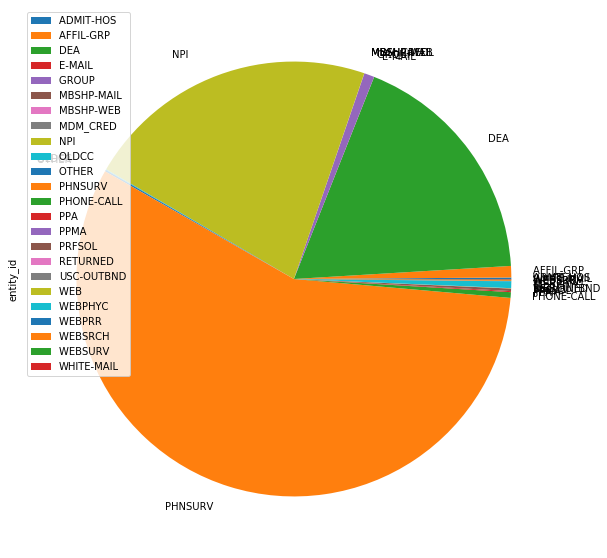

In [148]:
newer.groupby('src_cat_code').count()[['entity_id']].plot.pie(y='entity_id', figsize=(10, 10))

In [118]:
def get_zip_distance(zip1, zip2, dist):
    '''Get distances between zipcodes'''
    zip1 = clean_zipcode(zip1)
    zip2 = clean_zipcode(zip2)
    distance = dist.query_postal_code(zip1, zip2)*0.621371
    return distance

def clean_zipcode(zipcode):
    '''Format zipcode'''
    zipcode = str(zipcode)
    zipcode = zipcode.replace(" ", "")
    zipcode = zipcode.replace(".0", "")
    if len(zipcode) == 3:
        zipcode = "00"+zipcode
    if len(zipcode) == 4:
        zipcode = "0"+zipcode
    else:
        zipcode = zipcode[0:5]
    return zipcode

def get_zip_distances(df):
    '''Get all zip distances'''
    dists = []
    print("Removing significantly close addresses...")
    dist = pgeocode.GeoDistance('US')
    for row in df.itertuples():
        dists.append(get_zip_distance(row.ZIP_POLO, row.ZIP_PPMA, dist))
    df['POLO_DISTANCE'] = dists
    return df

In [117]:
filtered_polos[['ZIP_POLO','ZIP_PPMA']]

,ZIP_POLO,ZIP_PPMA
0,32610,27705
1,30384,32561
2,37203,35661
3,79936,83301
4,98661,94555
...,...,...
85282,43920,32940
85283,44115,61615
85284,32117,18925
85285,67114,96753


In [119]:
filtered_polos = get_zip_distances(filtered_polos)

Removing significantly close addresses...


In [121]:
filtered_polos.sort_values('POLO_DISTANCE')

,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,MAILING_LINE_1,...,POST_KEY,POST_CD_ID_PPMA,ADDR_1_PPMA,ADDR_2_PPMA,ADDR_3_PPMA,CITY_PPMA,STATE_CD,ZIP_PPMA,FROM_DT_PPMA,POLO_DISTANCE
9085,01103161220,A,1,1,JONATHAN D BROWNING MD,BROWNING,JONATHAN,DAVID,None,None,...,25839117,32224412,4844 Deer Lake Dr W,Ste 101,,Jacksonville,FL,32246,2021-04-30 20:44:36.212951,0.0
25040,02416990355,A,1,2,WILLIAM L KEOUGH MD,KEOUGH,WILLIAM,LAWRENCE,None,None,...,25843530,32229439,600 Grant St,Fl 11,UPMD Heath Plan,Pittsburgh,PA,15219,2021-05-03 20:46:42.577382,0.0
68909,30807810126,A,1,2,JOS A SANTIESTEBAN MD,SANTIESTEBAN,JOS,ANGEL,None,PRIMARY CARE GRP,...,25029413,26948264,5426 Mifflin Rd,Primary Care Grp,,Pittsburgh,PA,15207,2017-01-11 00:47:57.095009,0.0
45435,03901160821,A,1,2,MATTHEW J GRAVES MD,GRAVES,MATTHEW,JOHN,None,None,...,20036265,31576011,1227 Country Club Rd,Ste A,,McAlester,OK,74501,2020-08-14 21:10:48.488745,0.0
42870,03840111261,A,1,1,NICHOLAS A BOSTON MD,BOSTON,NICHOLAS,ANDREW,None,None,...,8200890,15599365,226 S Woods Mill Rd,Ste 49W,,Chesterfield,MO,63017,2020-03-03 21:09:23.262055,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84403,91381900016,A,1,2,YAN KATSNELSON MD,KATSNELSON,YAN,None,None,None,...,14750483,32097799,1052 Ave Ashford,Apt 1301,,San Juan,PR,00907,2021-03-05 20:45:27.604942,NaN
84407,91382870021,A,1,2,MIRA B ZELIN DO,ZELIN,MIRA,BORISOVNA,None,None,...,23605575,22864252,4129 Orchid Dr,,,Hernando Bch,FL,34607,2017-06-21 20:41:55.913458,NaN
84637,91503820353,A,1,1,AHMED ABOU ELMAGD MD,ABOU ELMAGD,AHMED,None,None,MANS DEL SUR,...,19891818,17965586,62 Calle Vigia,Mans Del Sur,Mansiones Del Sur,Coto Laurel,PR,00780,2021-04-27 20:45:31.184663,NaN
84745,91504810475,A,1,2,SHERIF A PHILIPS MD,PHILIPS,SHERIF,ANTOUN,None,None,...,13999739,31479255,16015 Ivy Lake Dr,,,Odessa,FL,33556,2020-07-10 21:15:17.617540,NaN


In [122]:
filtered_polos.hist(bins=3, column='POLO_DISTANCE')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001510B423E08>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015136F7AAC8>]],
      dtype=object)

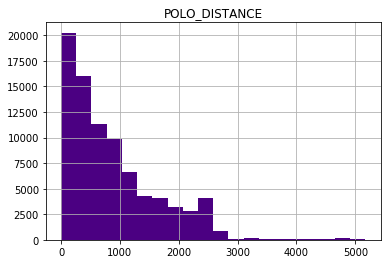

In [186]:
filtered_polos.dropna(subset=['POLO_DISTANCE']).hist(bins=20, column='POLO_DISTANCE', color='indigo')

In [141]:
filtered_polos.dropna(subset=['POLO_DISTANCE']).POLO_DISTANCE.median()

645.1911325555614

In [131]:
PPD[PPD.TOP_CD == 20]

,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,MAILING_LINE_1,...,POLO_ZIP,POLO_SECTOR,POLO_CARRIER_ROUTE,MOST_RECENT_FORMER_LAST_NAME,MOST_RECENT_FORMER_MIDDLE_NAME,MOST_RECENT_FORMER_FIRST_NAME,NEXT_MOST_RECENT_FORMER_LAST,NEXT_MOST_RECENT_FORMER_MIDDLE,NEXT_MOST_RECENT_FORMER_FIRST,PARTY_ID
0,00102000013,A,1,2,MICHAEL J STANFORD MD,STANFORD,MICHAEL,JAMES,None,None,...,None,None,None,None,None,None,None,None,None,1849563
2,00102000030,A,1,1,MARK T JACKSON MD,JACKSON,MARK,THOMAS,None,None,...,28805,1262,C082,None,None,None,None,None,None,1798000
3,00102000048,A,1,2,NADHIWAN S MAISIAK MD,MAISIAK,NADHIWAN,SAKARIN,None,None,...,85375,5282,C045,None,None,None,None,None,None,1843265
4,00102000056,A,1,2,RAJIV B GALA MD,GALA,RAJIV,BABULAL,None,None,...,70115,6949,C003,None,None,None,None,None,None,1888535
5,00102000064,A,1,2,CAROL L ADAMS MD,ADAMS,CAROL,LYNN,None,None,...,35504,2516,C009,DANIELS,LYNN,CAROL,None,None,None,1798272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281045,96501940019,A,1,1,MUKUL GUPTA MD,GUPTA,MUKUL,None,None,None,...,93105,4230,C013,None,None,None,None,None,None,2691884
1281046,96501950014,A,1,2,DINESH BHASKARAN MD,BHASKARAN,DINESH,None,None,None,...,15009,9727,R001,None,None,None,None,None,None,2889973
1281050,96501960036,A,1,2,KAMISHELE MAILA MD,MAILA,KAMISHELE,None,None,None,...,45801,4667,C005,None,None,None,None,None,None,3526200
1281051,96501960044,A,1,2,MWIZA GAUSI MD,GAUSI,MWIZA,None,None,None,...,24541,2987,C002,None,None,None,None,None,None,3572171


In [132]:
(819579-98272)/819579

0.880094536341219

In [244]:
(819579-98272+20994)/819579

0.9057101267846053

In [245]:
0.9057101267846053*0.7706

0.6979402237002168

In [279]:
(819579-98272)*0.7677

553747.3839

In [280]:
553747.3839+20994

574741.3839

In [281]:
(574741.3839)/819579

0.70126416599254

In [143]:
591966/819579

0.7222805855201267

In [144]:
(819579-98272+36127)/819579

0.9241744847049522

In [145]:
0.9241744847049522*0.7706

0.7121688579136362

In [151]:
newer.columns

Index(['entity_id', 'comm_id', 'src_cat_code', 'ENTITY_ID', 'PARTY_ID', 'ME',
       'RECORD_ID', 'UPDATE_TYPE', 'ADDRESS_TYPE', 'MAILING_NAME',
       ...
       'ADDR_3_PPMA', 'CITY_PPMA', 'STATE_PPMA', 'ZIP_PPMA', 'FROM_DT_PPMA',
       'POLO_NEWER', 'POST_CD_ID', 'DESC', 'CATEGORY_CODE', 'SOURCE'],
      dtype='object', length=108)

In [159]:
(sum([x.days for x in diffs])/len(diffs))/365.25

5.53045677118937

In [166]:
import datetime

today = datetime.datetime.today()

In [167]:
today

datetime.datetime(2021, 5, 5, 16, 2, 57, 446315)

In [168]:
polo_ages = []
ppma_ages = []
for row in newer.itertuples():
    polo_age = today - row.FROM_DT_POLO
    ppma_age = today - row.FROM_DT_PPMA
    polo_ages.append(polo_age)
    ppma_ages.append(ppma_age)

In [170]:
(sum([x.days for x in polo_ages])/len(polo_ages))/365.25

2.5634688577809213

In [171]:
(sum([x.days for x in ppma_ages])/len(ppma_ages))/365.25

8.095894423102074

In [175]:
newer['PPMA_AGE'] = [(x.days)/365.25 for x in ppma_ages]
newer['POLO_AGE'] = [(x.days)/365.25 for x in polo_ages]
newer['AGE_DIFFERENCE'] = [(x.days)/365.25 for x in diffs]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000150028C91C8>]],
      dtype=object)

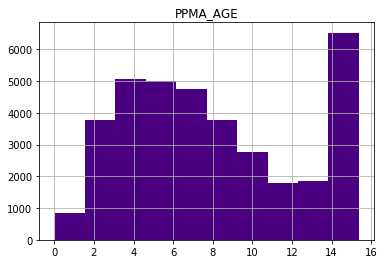

In [185]:
newer.hist(bins=10, column='PPMA_AGE', color='indigo')

In [188]:
humach = pd.read_csv('../../Data/Humach/humach_updated_since_2018.csv')

In [193]:
humach['ME']=fix_me(humach.PHYSICIAN_ME_NUMBER)

In [219]:
MERGE = pd.merge(newer, humach, right_on = ['ME','OFFICE_ADDRESS_STATE'], left_on=['ME','STATE_POLO'])

In [220]:
MERGE[['ZIP_POLO','OFFICE_ADDRESS_ZIP']]

,ZIP_POLO,OFFICE_ADDRESS_ZIP
0,32610,32610
1,53005,53005
2,45220,45220
3,38801,38801
4,38801,38801
...,...,...
24498,60521,60521
24499,60521,60521
24500,35801,35801
24501,33462,33462


In [205]:
newer['OFFICE_ADDRESS_LINE_2'] = [x.upper().replace('.','') for x in newer.ADDR_1_POLO]

In [242]:
true_merge.drop_duplicates('ME').groupby('src_cat_code').count()

,entity_id,comm_id,ENTITY_ID,PARTY_ID,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,LAST_NAME,...,Source,WSLIVE_SOURCE,WSLIVE_FILE_DT,MATCH_ADDR,MATCH_PHONE,MATCH_ADDR_LONG,SPECIALTY,SPECIALTY_UPDATED,SOURCE_FILE_DT,VALIDATED
src_cat_code,,,,,,,,,,,,,,,,,,,,,
ADMIT-HOS,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
AFFIL-GRP,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
DEA,150,150,150,150,150,150,150,150,150,150,...,150,150,150,150,150,150,150,150,150,150
E-MAIL,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
GROUP,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
MBSHP-WEB,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NPI,227,227,227,227,227,227,227,227,227,227,...,227,227,227,227,227,227,227,227,227,227
OLDCC,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
OTHER,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [243]:
2+5+150+1+17+1+227+1+2+34+1+9+2

452

In [224]:
from fuzzywuzzy import fuzz

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
    elif fuzz.ratio(thing_1, thing_2) > 70:
        return 1

In [236]:
def check_match(thing_1, thing_2):
    '''match check'''
    if thing_1 == thing_2:
        return 1
    elif thing_1 in thing_2 or thing_2 in thing_1:
        return 1
    elif fuzz.ratio(thing_1, thing_2) > 60:
        return 1
    else:
        return 0

In [232]:
MERGE = MERGE.fillna('None')

In [238]:
corrects =[]
for row in MERGE.itertuples():
    correct = True
    one = row.OFFICE_ADDRESS_LINE_2_x
    two = row.OFFICE_ADDRESS_LINE_2_y
    if check_match(one,two) == 0:
        print(f'{one} is not {two}')
        print(fuzz.ratio(one, two))
        print('')
        correct = False
    corrects.append(correct)

3316 HIGHWAY 280 is not 321 MEDICAL CENTER DR
32

2915 MISSOURI AVE is not 211 4TH ST
30

1919 STATE ST STE 140 is not 1407 SPRING ST  STE 1
52

2149 W 24TH ST STE B is not 2610 E UNIVERSITY DR
25

5501 WILLOW CREEK DR is not 500 S UNIVERSITY AVE
30

24 NORRIS ST is not 1555 EXCHANGE AVE
21

6002 N LIDGERWOOD ST is not 200 15TH AVE E
35

6002 N LIDGERWOOD ST is not 200 15TH AVE E
35

310 W SUPERIOR ST 2ND FL is not 1 EAST ERIE ST
47

2100 POWELL ST is not 1 MEDICAL PLAZA
28

605 W DEWITT HENRY DR STE C is not PO BOX 818
11

1721 W YOSEMITE AVE is not 11201 BENTON ST.
40

3291 LOMA VISTA RD is not 1334 E MAIN ST
44

115 NE 100TH ST STE 101 is not 1310 116TH AVE NE
25

1625 JUNIPER AVE is not 3111 CENTRAL POINT DR
27

18111 BROOKHURST ST # 5100 is not 618 5TH ST
39

20 YORK ST is not 35 PARK ST
60

115 MALL DR is not 2100 POWELL ST
40

877 OAK PARK BLVD is not 200 JOSE SIGURED AVE
22

9002 E DESERT COVE AVE STE 102 is not 7301 E 2ND
25

222 TONGASS DR is not PO BOX 130
25

501 EISENHOWER

1301 W PALM AVE is not 1235 SAN MARCO BLVD
41

8181 NW 154TH ST is not 1920 DON WICKHAM DR STE 215
37

2021 MIDWEST RD is not 8118 GOOD LUCK RD
38

10321 N 2274 RD is not 101 S MOORE AVE
40

3300 S FISKE BLVD is not 1421 MALABAR RD NE
17

1711 3RD ST is not 720 WOOD ST
55

8 MEMORIAL MEDICAL CT is not 1 SCIENCE CT
36

16230 SUMMERLIN RD is not 13535 NOMORSE PARKWAY
31

16230 SUMMERLIN RD is not 13535 NOMORSE PARKWAY
31

7450 HOSPITAL DR STE 370 is not 920 W MARKET ST STE 320
47

607 VIENTO DE AVILA is not 1350 HICKORY ST
24

133 HOSPITAL DR STE 700 is not 90 BENWOOD DR
28

9155 SW BARNES RD is not 960 16TH ST
29

STE 1204 is not 1710 GUNBARREL RD
16

PO BOX 160 is not HWY 491 N
21

2665 SCRIPTURE ST is not 209 N BONNEY BRAE ST
38

2665 SCRIPTURE ST is not 209 N BONNY BRA ST
34

1030 JEFFERSON AVE is not 625 N HIGHLAND AVE
33

204 WILD CHERRY RD is not 1875 HARDEN ST
25

2211 3RD AVE is not 1600 MEDICAL CENTER DR
24

4455 S PADRE ISLAND DR STE 11 is not 1734 SANTA FE ST
40

703 E MARSHA


1223 GATEWAY DR 2B is not 1421 STE 220
20

1223 GATEWAY DR 2B is not 1421 MALLOWBAR RD STE 220
14

10727 WHITE OAK AVE is not .
0

900 LANCASTER ST is not 101 BODIN CIR
34

16740 DAVIDSON CONCORD RD is not 501 BILLINGSLEY RD
33

2520 INDEPENDENCE BLVD STE 201 is not 3100 SPRING FOREST RD
31

3501 CRANBERRY BLVD is not 750 UNIVERSITY ROW
43

305 PARK CREEK DR is not PO BOX 2130
14

8170 33RD AVE S is not 9555 UPLAND LN N
26

1280 HOSPITAL DR UNIT 300 is not 17 CALEDON CT
32

1280 HOSPITAL DR UNIT 300 is not 17 CALEDON CT
32

310 W 9TH ST is not 295 STONER AVE
31

1100 SOUTHGATE STE 13 is not 135 SE 1ST ST
41

1100 SOUTHGATE STE 13 is not 135 SE FIRST ST
39

601 S CLIFF AVE STE A is not 1100 E 26TH ST
23

FL 3 is not 234 GOODMAN ST
11

8170 33RD AVE S is not 3605 MAYFAIR AVE
45

900 W NIFONG BLVD STE 125 is not 500 KEENE ST
38

142 S MAIN ST is not 620 JOHN PAUL JONES CIR
28

888 S KING ST is not 321 N KUAKINI ST
55

9 HOSPITAL PARK is not 3131 S MAIN ST
28

18220 TOMBALL PKWY STE 155 i

108 FORBES ST is not 12070 OLD LINE CENTER
29

PO BOX 646 is not 420 1/2 MAIN ST
16

700 ACKERMAN RD STE 2120 is not 2050 KENNY RD
49

1840 AMHERST ST is not 3300 GALLOWS RD
27

96 WILLARD ST is not 1351 BEDFORD DR
29

1800 WESTERN AVE STE 302 is not 1805 MEDICAL CENTER DR
39

405 W JACKSON ST is not 201 S 14TH ST
28

30 N 1900 E # 5R218 is not 50 N MEDICAL DR
35

9850 GENESEE AVE STE 940 is not 909 HYDE ST
40

1015 E 32ND ST STE 308 is not 9
0

9101 N CENTRAL EXPY STE 520 is not 2304 MIDWESTER PKWY
30

312 9TH ST SW is not 1015 DUFF AVE
23

UNIT 202 is not 1600 PRAIRE CTR PKWY
21

500 S UNIVERSITY AVE is not 6119 MIDTOWN AVE  STE201
27

500 S UNIVERSITY AVE is not 6119 MIDTOWN AVE STE 201
27

1007 GOODYEAR AVE is not 1653 N TEMPLE AVE
41

105 N BASCOM AVE STE 201 is not 1000 W CARSON ST
35

98-1079 MOANALUA RD is not 1319 PUNAHOU
39

1910 ROYALTY DR is not 2140 GRAND AVE   STE 120
36

3185 N LESLIE RD is not 1313 E 32ND ST
40

2415 PARKWOOD DR is not 1350 WALTON WAY
32

315 CAMINO DEL

In [239]:
MERGE['VALIDATED']=corrects

In [241]:
true_merge = MERGE[MERGE.VALIDATED==True]

In [255]:
ppd[ppd.FIRST_NAME=="DE'ANDRE"].POLO_MAILING_LINE_2

226286    NaN
Name: POLO_MAILING_LINE_2, dtype: object

In [251]:
ppd.groupby('TOP_CD').count()

,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,MAILING_LINE_1,...,POLO_STATE,POLO_ZIP,POLO_SECTOR,POLO_CARRIER_ROUTE,MOST_RECENT_FORMER_LAST_NAME,MOST_RECENT_FORMER_MIDDLE_NAME,MOST_RECENT_FORMER_FIRST_NAME,NEXT_MOST_RECENT_FORMER_LAST,NEXT_MOST_RECENT_FORMER_MIDDLE,NEXT_MOST_RECENT_FORMER_FIRST
TOP_CD,,,,,,,,,,,,,,,,,,,,,
12,122864,122864,122864,121406,122864,122856,122862,87062,2228,30431,...,51745,51745,51553,51630,5004,2943,5004,143,96,143
20,819579,819579,819579,810589,819579,819566,819567,672157,22845,143859,...,720968,721286,712124,714720,190762,159617,190766,22075,17387,22075
30,13107,13107,13107,12869,13107,13107,13107,11685,620,2808,...,9967,9999,9817,9868,4528,4030,4527,596,497,596
40,12305,12305,12305,12090,12305,12304,12304,10161,374,3098,...,10225,10263,10106,10152,3371,2943,3371,390,330,390
50,12642,12642,12642,12342,12642,12642,12642,10738,450,3689,...,9817,9894,9677,9728,3759,3251,3759,433,355,433
62,4687,4687,4687,4610,4687,4687,4687,4003,145,627,...,3194,3199,3161,3178,1557,1358,1557,240,197,240
71,167433,167433,167433,162845,167433,167430,167433,144218,9246,18682,...,88362,88933,85756,86906,64982,56139,64981,7731,6326,7732
72,19420,19420,19420,19194,19420,19420,19420,16617,931,1716,...,14317,14320,14087,14186,7599,6434,7599,1048,834,1048
74,3997,3997,3997,3936,3997,3997,3997,3315,79,304,...,1284,1285,1237,1252,1699,1418,1699,255,197,255


In [258]:
for col in true_merge.columns:
    print(col)

entity_id
comm_id
src_cat_code
ENTITY_ID
PARTY_ID
ME
RECORD_ID
UPDATE_TYPE
ADDRESS_TYPE
MAILING_NAME
LAST_NAME
FIRST_NAME
MIDDLE_NAME
SUFFIX_x
MAILING_LINE_1
MAILING_LINE_2
CITY
STATE
ZIP
SECTOR
CARRIER_ROUTE
ADDRESS_UNDELIVERABLE_FLAG
FIPS_COUNTY
FIPS_STATE
PRINTER_CONTROL_CODE
PC_ZIP
PC_SECTOR
DELIVERY_POINT_CODE
CHECK_DIGIT
PRINTER_CONTROL_CODE_2
REGION
DIVISION
GROUP
TRACT
SUFFIX_CENSUS
BLOCK_GROUP
MSA_POPULATION_SIZE
MICRO_METRO_IND
CBSA
CBSA_DIV_IND
MD_DO_CODE
BIRTH_YEAR
BIRTH_CITY
BIRTH_STATE
BIRTH_COUNTRY
GENDER
TELEPHONE_NUMBER
PRESUMED_DEAD_FLAG
FAX_NUMBER
TOP_CD
PE_CD
PRIM_SPEC_CD
SEC_SPEC_CD
MPA_CD
PRA_RECIPIENT
PRA_EXP_DT
GME_CONF_FLG
FROM_DT
TO_DT
YEAR_IN_PROGRAM
POST_GRADUATE_YEAR
GME_SPEC_1
GME_SPEC_2
TRAINING_TYPE
GME_INST_STATE
GME_INST_ID
MEDSCHOOL_STATE
MEDSCHOOL_ID
MEDSCHOOL_GRAD_YEAR
NO_CONTACT_IND
NO_WEB_FLAG
PDRP_FLAG
PDRP_START_DT
POLO_MAILING_LINE_1
POLO_MAILING_LINE_2
POLO_CITY
POLO_STATE
POLO_ZIP
POLO_SECTOR
POLO_CARRIER_ROUTE
MOST_RECENT_FORMER_LAST_NAME
MO

In [259]:
true_merge.sort_values('WSLIVE_FILE_DT')

,entity_id,comm_id,src_cat_code,ENTITY_ID,PARTY_ID,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,...,Source,WSLIVE_SOURCE,WSLIVE_FILE_DT,MATCH_ADDR,MATCH_PHONE,MATCH_ADDR_LONG,SPECIALTY,SPECIALTY_UPDATED,SOURCE_FILE_DT,VALIDATED
7493,10727713,9841806,PHNSURV,10727713,2437305,04813790446,A,1,1,B K GORDON MD,...,VT,UPDATED,01/03/2020,048137904495491786,04813790449099464222,None,FM,1,12/19/2019,True
14954,28355050,933186,PHNSURV,28355050,3559569,02312081566,A,1,1,ALISON T SMITH MD,...,VT,UPDATED,01/03/2020,0231208156950044195,2312081562164457843,None,GS,1,12/19/2019,True
23066,44838140,24237413,PHNSURV,44838140,6168012,05502150458,A,1,2,ANDREW D MYERS MD,...,VT,UPDATED,01/03/2020,055021504514653147,05502150452622495000,None,IM,1,12/19/2019,True
17222,39080466,24237393,PHNSURV,39080466,4573848,01102100952,A,1,1,ALLEN M SANCHEZ MD,...,VT,UPDATED,01/03/2020,0110210095161933033,1102100953052479292,None,DR,1,12/19/2019,True
15589,28750744,24237410,PHNSURV,28750744,3590002,04815090662,A,1,1,AIMEE K WU MD,...,CR,UPDATED,01/03/2020,0481509066662177030,04815090668328261380,None,PD,1,12/19/2019,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,1905965,25608900,PHNSURV,1905965,1855709,00514981531,A,1,2,SUSAN A HOPPE MD,...,VT,UPDATED,12/31/2020,0051498153121655812,00514981532187268709,None,IM,1,10/29/2020,True
14757,28269978,20031635,PHNSURV,28269978,3553026,04706080771,A,1,2,SHAWN M ALLEN MD,...,VT,UPDATED,12/31/2020,0470608077288080304,04706080773034426647,None,OTO,1,11/20/2020,True
12180,22153764,19856707,PHNSURV,22153764,3407142,70409990230,A,1,2,YASSER REHMAN MD,...,Q,UPDATED,12/31/2020,7040999023101608,70409990235083636515,None,HO,1,11/20/2020,True
10808,16249138,25608884,PHNSURV,16249138,2952961,03845030803,A,1,2,SUSAN E WILLIAMS MD,...,VT,UPDATED,12/31/2020,038450308010139475,03845030806017942224,None,IM,1,10/29/2020,True


In [261]:
true_merge['FILE_DATE'] = pd.to_datetime(true_merge.WSLIVE_FILE_DT)

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [264]:
goop = true_merge.sort_values('FILE_DATE').drop_duplicates('ME', keep='last')

In [266]:
goop['FILE_YEAR'] = [x.year for x in goop.FILE_DATE]

In [278]:
goop.groupby('FILE_YEAR').count()[['entity_id']].plot(kind='bar', legend=False, color='indigo', xlabel='Year', ylabel='Count', title = 'Most Recent Verified Date')

SyntaxError: keyword can't be an expression (<ipython-input-278-e6742c1225d1>, line 1)

In [282]:
goop

,entity_id,comm_id,src_cat_code,ENTITY_ID,PARTY_ID,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,...,WSLIVE_FILE_DT,MATCH_ADDR,MATCH_PHONE,MATCH_ADDR_LONG,SPECIALTY,SPECIALTY_UPDATED,SOURCE_FILE_DT,VALIDATED,FILE_DATE,FILE_YEAR
4223,6456719,20481850,PHNSURV,6456719,2261221,02879850153,A,1,1,MICHAEL D JACOBSON DO,...,05/04/2018,0287985015226145406,2879850159377344141,None,FM,1,None,True,2018-05-04,2018
13176,27110638,6219725,PHNSURV,27110638,3463868,02878991861,A,1,2,PAUL H NEAL DO,...,05/04/2018,0287899186110447978,2878991862198662000,None,US,1,None,True,2018-05-04,2018
22602,44484761,20759524,PHNSURV,44484761,6096906,30501136332,A,1,1,ADAM M ROSS MD,...,05/04/2018,3050113633365130909,30501136337066513232,None,IM,1,None,True,2018-05-04,2018
5904,8692797,18583627,PHNSURV,8692797,2384865,03844951034,A,1,1,CRISTINE RADOJICIC MD,...,05/04/2018,0384495103182127705,3844951039196207300,None,AI,1,None,True,2018-05-04,2018
18541,39715568,18357179,PHNSURV,39715568,4897476,03305111430,A,1,1,KENNETH CERRETA III MD,...,05/04/2018,033051114343033756,3305111437274430611,None,PCC,1,None,True,2018-05-04,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17624,39191460,25841661,PHNSURV,39191460,4597017,04177061978,A,1,2,RICHARD J HATMAN DO,...,04/30/2021,041770619740193101,04177061978059634785,None,FM,1,04/05/2021,True,2021-04-30,2021
17572,39178499,11059099,PHNSURV,39178499,4581936,03601101024,A,1,2,MUSHENI NSA MD,...,04/30/2021,036011010250073109,03601101024056326688,None,PD,1,04/05/2021,True,2021-04-30,2021
3906,6117861,1302017,PHNSURV,6117861,2319425,02802941288,A,1,2,NANCY C MULLER MD,...,04/30/2021,02802941281113363136,02802941283146535000,None,HMP,1,04/05/2021,True,2021-04-30,2021
21146,43060585,9186289,PHNSURV,43060585,5606276,01643130692,A,1,1,SARAH E ROCHA MD,...,04/30/2021,016431306944503103,01643130696036684079,None,CHP,1,04/05/2021,True,2021-04-30,2021


In [283]:
MERGE

,entity_id,comm_id,src_cat_code,ENTITY_ID,PARTY_ID,ME,RECORD_ID,UPDATE_TYPE,ADDRESS_TYPE,MAILING_NAME,...,Source,WSLIVE_SOURCE,WSLIVE_FILE_DT,MATCH_ADDR,MATCH_PHONE,MATCH_ADDR_LONG,SPECIALTY,SPECIALTY_UPDATED,SOURCE_FILE_DT,VALIDATED
0,1234827,23584424,PHNSURV,1234827,1903170,00102000200,A,1,2,CHARLES R BLAKE MD,...,Z,UPDATED,06/07/2019,0010200020200032610,102000203522657080,None,OPH,1,None,True
1,1236621,13791447,PHNSURV,1236621,1888552,00102002351,A,1,1,SUNNY C YUNG MD,...,VT,UPDATED,11/22/2019,00102002351380053005,102002352627544488,None,ID,1,11/01/2019,True
2,1238467,3657743,PHNSURV,1238467,1798033,00102011678,A,1,2,THOMAS J BENDER MD,...,VT,UPDATED,04/02/2021,0010201167334545220,00102011675138724222,None,OM,1,03/02/2021,True
3,1238532,1427986,PHNSURV,1238532,1891465,00102011848,A,1,1,AMY R DOYLE MD,...,Q,UPDATED,12/25/2020,001020118483038801,00102011846623773000,None,ID,1,12/21/2020,True
4,1238532,1427986,PHNSURV,1238532,1891465,00102011848,A,1,1,AMY R DOYLE MD,...,Q,UPDATED,01/29/2021,001020118483038801,00102011846623773000,None,ID,1,01/04/2021,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24498,54982054,958722,PHNSURV,54982054,14244572,03575161323,A,1,2,CHRISTOPHER S DURKIN DO,...,VT,UPDATED,11/08/2019,035751613255060521,3575161326303236116,None,US,1,11/01/2019,True
24499,54982054,958722,PHNSURV,54982054,14244572,03575161323,A,1,2,CHRISTOPHER S DURKIN DO,...,CR,UPDATED,08/07/2020,035751613255060521,03575161326303236116,None,US,1,07/27/2020,True
24500,54993754,722146,PHNSURV,54993754,14247467,01875141631,A,1,2,MICHAEL K HOGER DO,...,VT,UPDATED,12/31/2020,0187514163200635801,01875141632562651000,None,US,1,10/29/2020,True
24501,57221317,1136261,PHNSURV,57221317,14742794,06701090223,A,1,2,ELIE M DONATH MD,...,VT,UPDATED,06/19/2020,0670109022530133462,06701090225619657300,None,IM,1,06/15/2020,True


In [286]:
filtered_dpc[filtered_dpc.POLO_NEWER == False].to_csv('../../Data/POLO_Filter/Filtered_POLOs_Older.csv', index=False)